# Self-Driving Car Engineer Nanodegree

## Project: **Advanced Lane Finding** 

### 06.Determine the curvature of the lane and vehicle position with respect to center

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

### Load Camera parameters for Pkl

In [2]:
import pickle
fh = open('Camera_parameters.pkl', 'rb')
mtx = pickle.load(fh)
dist = pickle.load(fh)
fh.close()

In [3]:
def abs_sobel_thresh(img, orient='y', sobel_kernel=5, thresh=(60, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, (orient=='x'), (orient=='y'), ksize= sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, (orient=='x'), (orient=='y'), ksize= sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def HLS_S_threshold(img, threshold=(200, 255)):

    HLS_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    HLS_S_img = HLS_img[:,:,2]
    
    HLS_S_img = HLS_S_img*(255/np.max(HLS_S_img))
    
    binary_output = np.zeros_like(HLS_S_img)
    
    binary_output[(HLS_S_img > threshold[0]) & (HLS_S_img <= threshold[1])] = 1

    return binary_output
def combine_binary(binary_image1, binary_image2): 
    combined_binary = np.zeros_like(binary_image2)
    combined_binary[(binary_image1 == 1) | (binary_image2 == 1)] = 1
    return combined_binary
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def unwarp(img):
    image_size = (img.shape[1], img.shape[0])
    src = np.float32([(585,460),
                  (700,460), 
                  (260,680), 
                  (1000,680)])

    dst = np.float32([(300,0),
                      (image_size[0]-300,0),
                      (300,image_size[1]),
                      (image_size[0]-300,image_size[1])])
    img_size = (img.shape[1], img.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

### Load each birds eye view image and use color transforms, gradients.

### Slide Windows

In [4]:
def find_lane_pixels(binary_warped):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # HYPERPARAMETERS
    # Set the width of the windows +/- margin
    margin = 100
    # Find our lane pixels first
    leftx, lefty, rightx, righty= find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty



    left_curverad, right_curverad, center_miss = measure_curvature_pixels_in_realworld(ploty, leftx, lefty, rightx, righty, left_fit, right_fit)
    ## Visualization ##
    # Colors in the left and right lane regions
    # Create an output image to draw on and visualize the result
    out_img = np.zeros((binary_warped.shape[0],binary_warped.shape[1],3), np.uint8)
    
    window_img = np.zeros_like(out_img)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return result, left_curverad, right_curverad, center_miss, left_fit, right_fit

In [5]:
def measure_curvature_pixels_in_realworld(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    # meters per pixel in y dimension
    ym_per_pix = 30/720 
    # meters per pixel in x dimension
    xm_per_pix = 3.7/720 
    # Reverse to match top-to-bottom in y
    leftx = leftx[::-1]  
    # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  
    
    y_eval = np.max(ploty)

    left_lane = np.mean(left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])

    right_lane = np.mean(right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])

    car_position = combined_binary.shape[1]/2

    center_lane_point = (left_lane + right_lane) /2

    center_miss = (car_position - center_lane_point) * xm_per_pix

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)

    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, center_miss

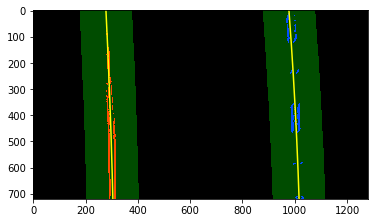

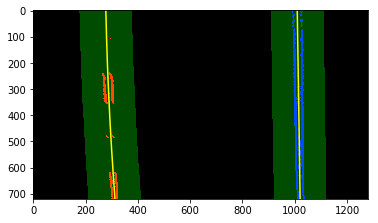

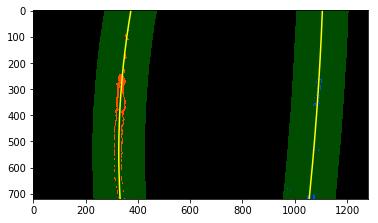

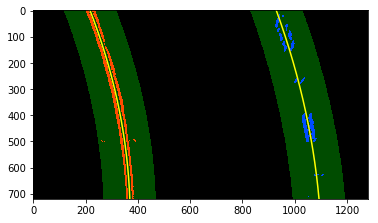

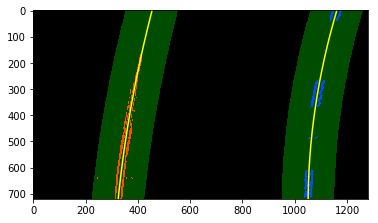

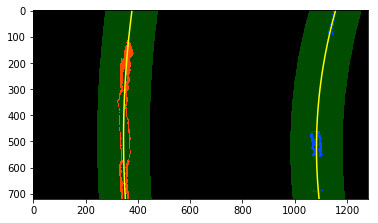

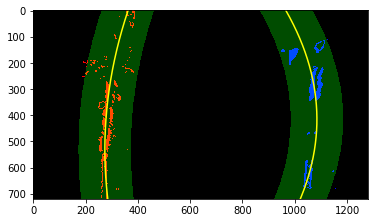

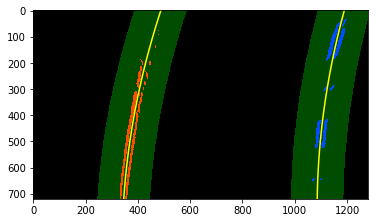

In [6]:
for image_name in os.listdir("output_images/Birds_Eye_View/"):
    #read in each image
    image = mpimg.imread("output_images/Birds_Eye_View/" + image_name)
    #Applies a Gaussian Noise kernel
    blur_image = gaussian_blur(image, kernel_size=7)
    
    binary_image1 = abs_sobel_thresh(blur_image,orient='x',thresh=(60, 255))
    
    binary_image2 = HLS_S_threshold(blur_image, threshold=(160, 190))
    
    combined_binary = combine_binary(binary_image1, binary_image2)
    #if(not video)
    fit_image, left_curverad, right_curverad, center_miss, left_fit, right_fit= fit_polynomial(combined_binary)
    
    plt.imshow(fit_image)
    plt.show()

In [7]:
def find_lane_pixels(binary_warped):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # HYPERPARAMETERS
    # Set the width of the windows +/- margin
    margin = 100
    # Find our lane pixels first
    leftx, lefty, rightx, righty= find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty



    left_curverad, right_curverad, center_miss = measure_curvature_pixels_in_realworld(ploty, leftx, lefty, rightx, righty, left_fit, right_fit)
    ## Visualization ##
    # Colors in the left and right lane regions
    # Create an output image to draw on and visualize the result
    out_img = np.zeros((binary_warped.shape[0],binary_warped.shape[1],3), np.uint8)
    
    window_img = np.zeros_like(out_img)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return result, left_curverad, right_curverad, center_miss, left_fit, right_fit

def measure_curvature_pixels_in_realworld(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    # meters per pixel in y dimension
    ym_per_pix = 30/720 
    # meters per pixel in x dimension
    xm_per_pix = 3.7/680 
    # Reverse to match top-to-bottom in y
    leftx = leftx[::-1]  
    # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  
    

    left_lane = np.mean(left_fit[0]*combined_binary[0]**2 + left_fit[1]*combined_binary[0] + left_fit[2])

    right_lane = np.mean(right_fit[0]*combined_binary[0]**2 + right_fit[1]*combined_binary[0] + right_fit[2])

    car_position = combined_binary.shape[1]/2

    center_lane_point = (left_lane + right_lane) /2

    center_miss = (car_position - center_lane_point) * xm_per_pix

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)

    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, center_miss

CurveRadius: 21286.89510420297
Center distance: 0.06612799505085389


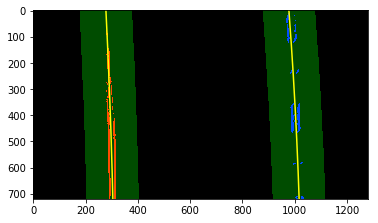

CurveRadius: 28419.14425303825
Center distance: -0.016784793093856616


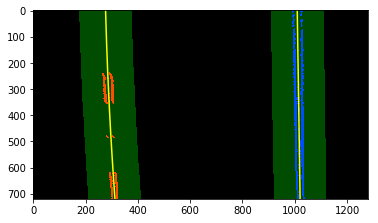

CurveRadius: 1878.2164411332963
Center distance: -0.5351852911017305


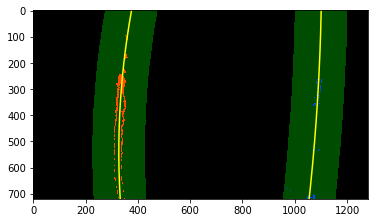

CurveRadius: 1395.3864098267945
Center distance: 0.3616385470882166


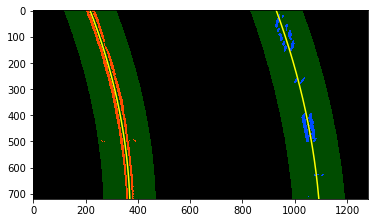

CurveRadius: 849.1559012791342
Center distance: -0.9105430856579179


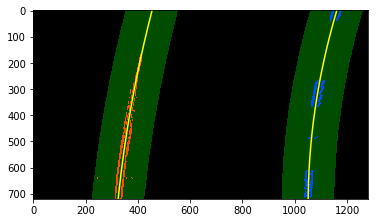

CurveRadius: 9333.074766689917
Center distance: -0.6875768011024627


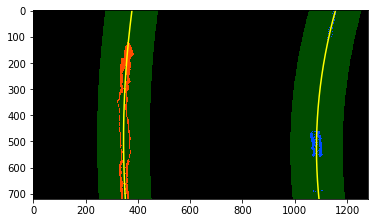

CurveRadius: 506.5797665225467
Center distance: -0.12167096867302415


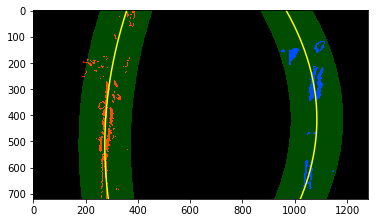

CurveRadius: 961.1893631131227
Center distance: -1.0778083199797377


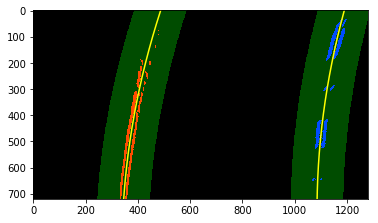

In [8]:
for image_name in os.listdir("output_images/Undistorted_Image/"):
    #read in each image
    image = mpimg.imread("output_images/Undistorted_Image/" + image_name)
    Birds_Eye_View_image, M, Minv = unwarp(image)

    original_image = mpimg.imread("test_images/" + image_name)
    
    #Applies a Gaussian Noise kernel
    blur_image = gaussian_blur(Birds_Eye_View_image, kernel_size=7)
    
    binary_image1 = abs_sobel_thresh(blur_image,orient='x',thresh=(60, 255))
    
    binary_image2 = HLS_S_threshold(blur_image, threshold=(160, 190))
    
    combined_binary = combine_binary(binary_image1, binary_image2)
    #if(not video)
    fit_image, left_curverad, right_curverad, center_miss, left_fit, right_fit= fit_polynomial(combined_binary)
    print("CurveRadius: " + str((left_curverad+right_curverad)/2))
    print("Center distance: " + str((center_miss)))
    plt.imshow(fit_image)
    plt.show()